In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader

In [2]:
n_range = range(1, 1+200)
N = len(n_range)
SXM_PATH = ["electromigration_30/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 11
detect_kwargs = {
    'minmass' : 2,
    'maxsize' : 4,
    'separation' : 5,
}
f = tp.batch(frames[:], molecule_size, **detect_kwargs)

Frame 199: 12 features


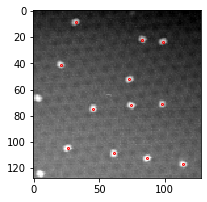

(-0.5, 127.5, 127.5, -0.5)

In [3]:
fig=plt.figure(figsize=(3, 5))
idx = 12
ax = tp.annotate(f[f['frame']==idx], frames[idx], plot_style={'markersize':1})
ax.axis('off')

Frame 199: 12 trajectories present.


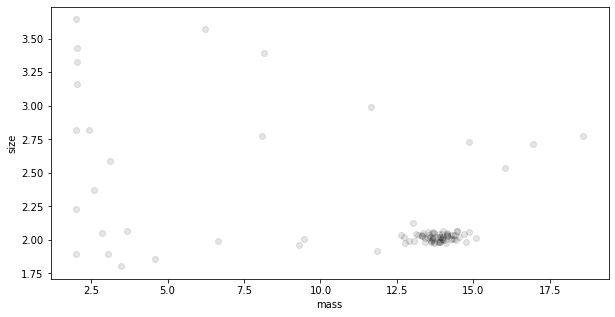

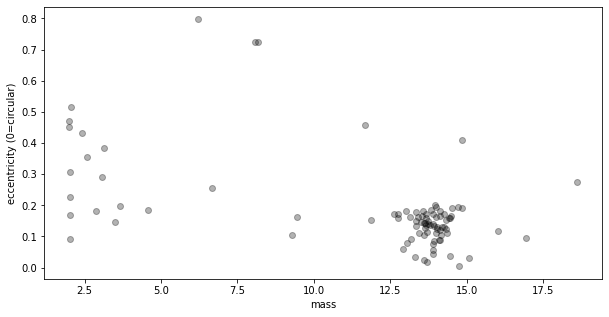

In [4]:
search_kws = {
    'search_range' : 30,
    'adaptive_stop' : 2.0,
    'adaptive_step' : 0.95,
}
t = tp.link(f, **search_kws)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [5]:
min_mass, max_mass = 9, 14
min_size, max_size = 1.8, 2.2
min_ecc, max_ecc = 0.05, 0.3
t1 = t[t['ecc'].between(min_ecc, max_ecc) &
       t['size'].between(min_size, max_size) & 
       t['mass'].between(min_mass, max_mass)]
t2 = tp.filter_stubs(t, 30)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 92
After: 18


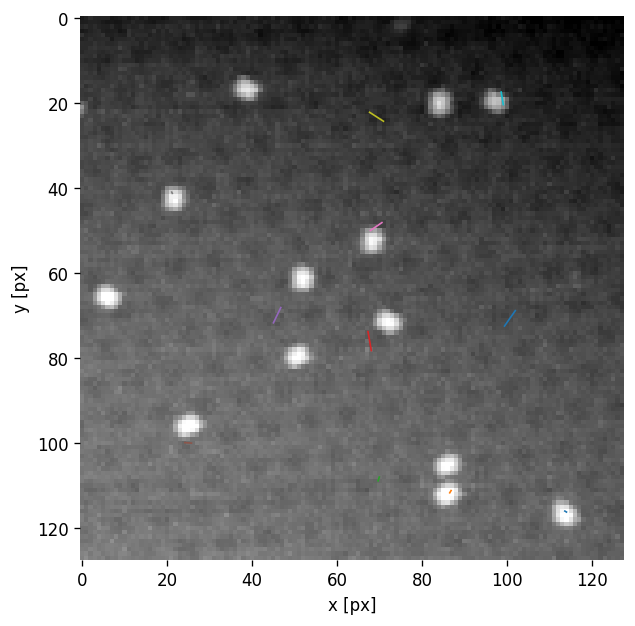

In [10]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig=plt.figure(figsize=(8, 6), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
plt.axis('off')
ln, = ax1.plot([], [], lw=3)
ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
def animate(i):
    plt.cla()
    tp.plot_traj(t2[(t2['frame']<=1)], superimpose=frames[i], label=False, ax=ax1, plot_style={'alpha' : 1})
    ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
    plt.imshow(frames[i], cmap='gray')
# Set up formatting for the movie files
Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
line_ani = matplotlib.animation.FuncAnimation(fig, animate, frames=30)
# line_ani.save('claymation.mp4', writer=writer)
line_ani

# MSD

In [315]:
d = tp.compute_drift(t2)
tm = tp.subtract_drift(t2.copy(), d)
tm.head(3)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,30.512413,28.906653,3.840074,1.902541,0.187534,0.274563,-13.115367,-0.017731,0,0
0,101.076221,92.833409,4.177558,1.833060,0.229739,0.308884,49.550714,-0.230571,0,5
0,103.971480,118.598930,5.348265,3.138798,0.628408,0.276470,53.911004,-1.399188,0,6


/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


(0.0, 25.0)

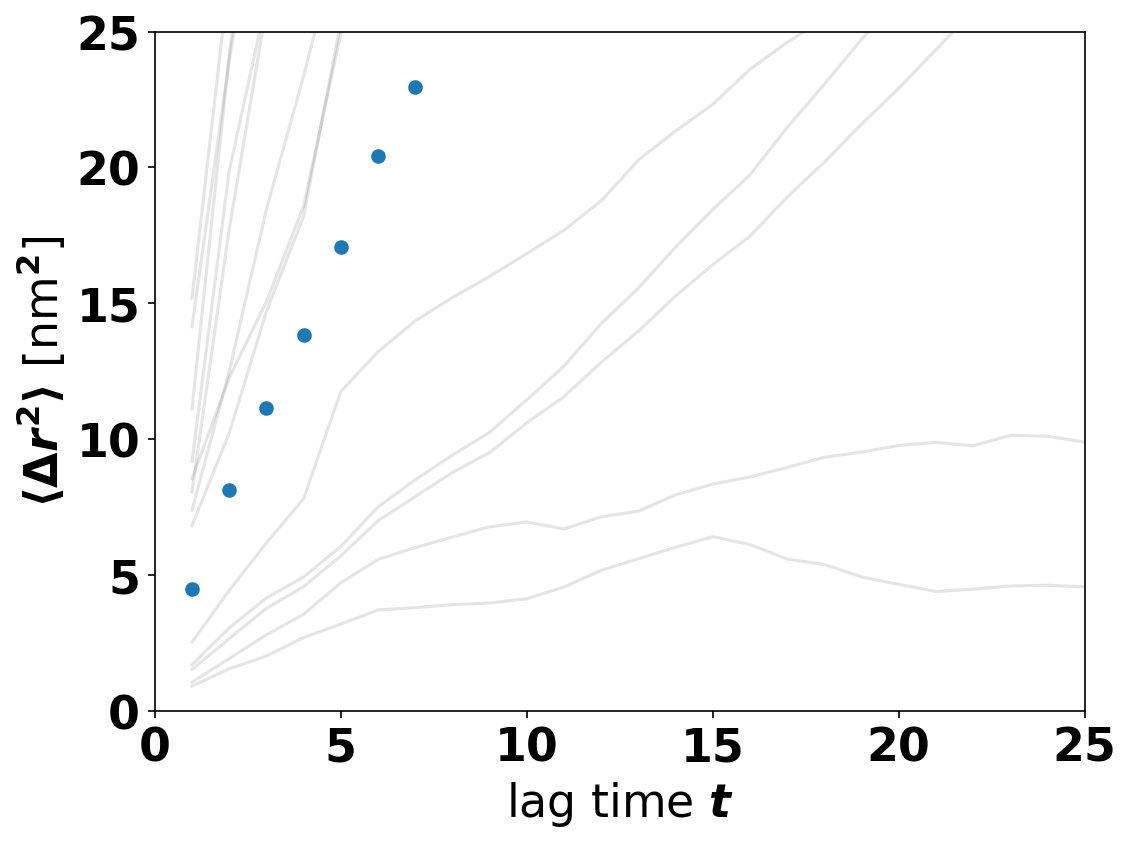

In [316]:
im = tp.imsd(tm, frames.meters_per_pixel * 1e6, 1) * 1e6
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(im.index, im , 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
# ax.set_xscale('log')
# ax.set_yscale('log')
em = tp.emsd(tm, frames.meters_per_pixel * 1e6, 1) * 1e6
ax.plot(em.index, em, 'o')
ax.set_xlim(0, 25)
ax.set_ylim(0, 25)

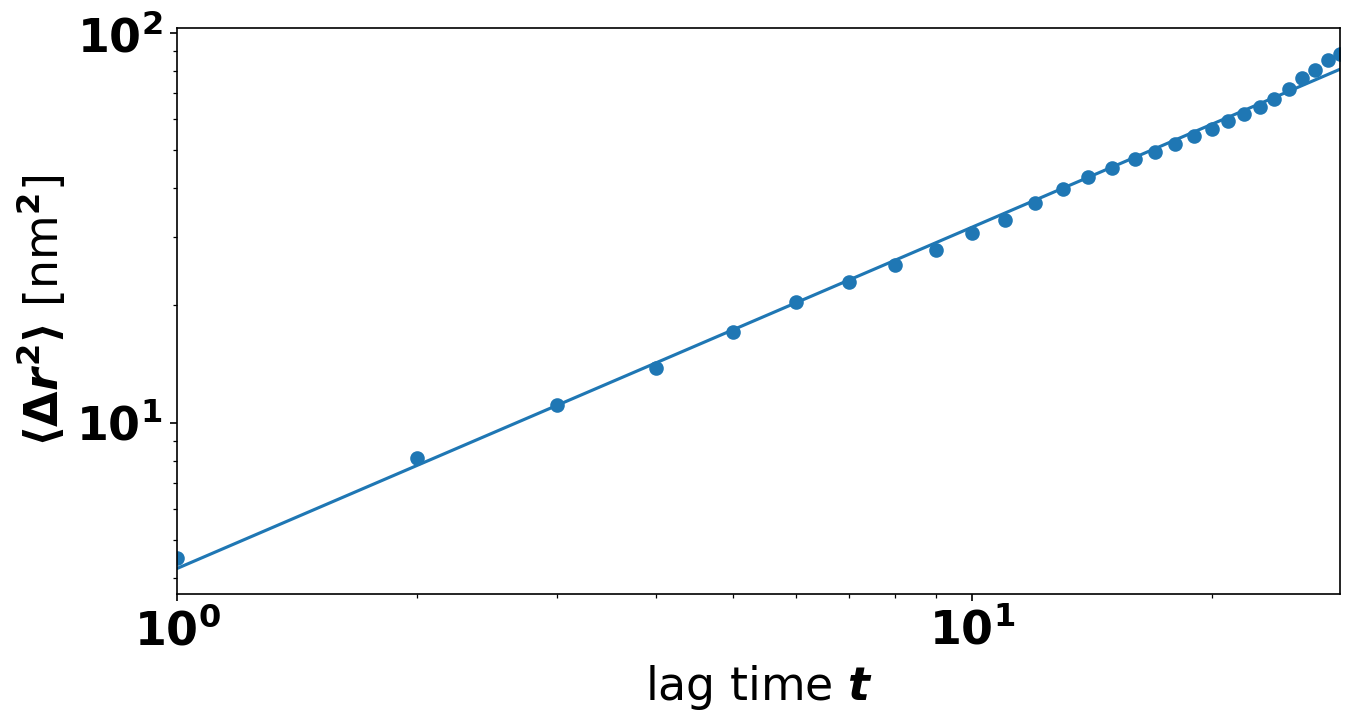

,n,A
msd,0.874546,4.239276


In [317]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [nm$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em[:30])  # performs linear best fit in log space, plots]

# Deep Learning Classification

In [318]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)

In [319]:
from tensorflow.keras.models import load_model
diff_class = {0 : 'fbm', 1 : 'brownian', 2 : 'ctrw'}
def classification_on_real(dx):
    N=np.shape(dx)[0]
    net_file = '../moire_walk/models/classification_model_30.h5'
    model = load_model(net_file)
    predictions = []
    y_preds = []
    for j in range(N):
        dummy = np.zeros((1,29,1))
        dummy[0,:,:] = np.reshape(dx[j,:], (29, 1))
        y_pred = model.predict(dummy) # get the results for 1D 
        ymean = np.mean(y_pred,axis=0) # calculate mean prediction of N-dimensional trajectory 
        prediction = np.argmax(ymean,axis=0) # translate to classification
        predictions.append(prediction)
        print('particle {} --> {}'.format(j + 1, diff_class[prediction]))
        print('y_pred {}'.format(y_pred))
        y_preds.append(y_pred[0])
    return y_preds

# [print(x.shape) for x in paths]
# long_paths = [x[:30,1] for x in paths if x.shape[0] > 30]
num_steps = t3.particle.value_counts()
long_track_id = num_steps.index[num_steps >= 30]
long_paths = [t3[t3.particle == idx].x.values[:30] for idx in long_track_id]
x1 = np.array(long_paths)
x1 = x1-np.mean(x1)     
x_n = x1
dx = np.diff(x_n)
y_preds = classification_on_real(dx)
print(np.mean(y_preds, axis=0))

particle 1 --> fbm
y_pred [[0.6329426  0.36078066 0.00627672]]
particle 2 --> brownian
y_pred [[0.49221307 0.5005495  0.00723741]]
particle 3 --> brownian
y_pred [[0.46840948 0.5276648  0.00392574]]
particle 4 --> brownian
y_pred [[0.02914516 0.9664523  0.00440252]]
particle 5 --> ctrw
y_pred [[1.6794501e-09 3.5664115e-02 9.6433586e-01]]
particle 6 --> brownian
y_pred [[1.1386926e-14 9.9954742e-01 4.5253191e-04]]
particle 7 --> brownian
y_pred [[2.9235639e-15 9.9999988e-01 1.2686402e-07]]
particle 8 --> brownian
y_pred [[1.8654494e-21 9.9999666e-01 3.3295471e-06]]
particle 9 --> brownian
y_pred [[8.9815126e-12 9.9859458e-01 1.4054116e-03]]
particle 10 --> ctrw
y_pred [[1.3415091e-05 1.7018443e-01 8.2980216e-01]]
particle 11 --> brownian
y_pred [[6.4254166e-17 8.5377288e-01 1.4622708e-01]]
particle 12 --> brownian
y_pred [[7.7942193e-16 9.9910778e-01 8.9224480e-04]]
particle 13 --> brownian
y_pred [[3.1861343e-11 9.8850095e-01 1.1499029e-02]]
[0.12482491 0.7231397  0.1520354 ]


## Alpha Estimation

In [103]:
def alpha_on_real(dx):
    N=np.shape(dx)[0]
    net_file = 'models/20_alpha_model.h5'
    model = load_model(net_file)
    predictions = []
    for j in range(N):
        dummy = np.zeros((1,19,1))
        dummy[0,:,:] = np.reshape(dx[j,:], (19, 1))
        y_pred = model.predict(dummy) # get the results for 1D 
        ymean = np.mean(y_pred,axis=0) # calculate mean prediction of N-dimensional trajectory 
        predictions.append(ymean)
        print('particle {} --> {}'.format(j + 1, ymean))
    return predictions
# [print(x.shape) for x in paths]
# long_paths = [x[:30,1] for x in paths if x.shape[0] > 30]
num_steps = t3.particle.value_counts()
long_track_id = num_steps.index[num_steps >= 20]
long_paths = [t3[t3.particle == idx].x.values[:20] for idx in long_track_id]
x1 = np.array(long_paths)
x1 = x1-np.mean(x1)     
x_n = x1
dx = np.diff(x_n)
alphas = np.array(alpha_on_real(dx))
np.mean(alphas)

particle 1 --> [0.9361471]
particle 2 --> [0.89103067]
particle 3 --> [0.9170617]
particle 4 --> [0.88698757]
particle 5 --> [0.99078596]
particle 6 --> [0.9912815]
particle 7 --> [0.9924372]
particle 8 --> [0.9915724]
particle 9 --> [0.9794949]
particle 10 --> [0.8662638]
particle 11 --> [0.9982437]
particle 12 --> [0.9811369]
particle 13 --> [0.9983692]


0.9554471

In [100]:
displacements = np.concatenate(paths)*frames.meters_per_pixel*1e9
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
print("The mean square displacement is: ", (dists**2).mean(), "nm")
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
plt.hist(dists, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 15);
plt.figure(figsize=(5,5));
import seaborn as sns
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
#g = sns.jointplot(x="dx", y="dy", data=displacement_df)
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.grid()
ax.set_aspect('equal', 'box')
plt.figure(figsize=(5,5));
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
ax.set_aspect('equal', 'box')

NameError: name 'paths' is not defined

In [ ]:
t3.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
def msd(df):
    df['time'] = df['frame'] - df['frame'].iloc[0]
    x0, y0 = df.x.iloc[0], df.y.iloc[0]
    df['msd'] = (df.x - x0) ** 2 + (df.y - y0) ** 2
    return df
msds = t3.groupby('particle').apply(lambda x : msd(x))
# plt.figure(figsize=(5, 5))
sns.lineplot(data=msds, x='time', y='msd')
# sns.regplot(data=msds, x='time', y='msd', scatter=False)
ser = msds.groupby('time').msd.mean()
# ser.plot()
# msds.groupby('time').size().plot()
# (ser.iloc[1:] / 30).plot()
END_RANGE = 60
reg = LinearRegression(fit_intercept = False).fit(ser.index.values[1:5].reshape(-1, 1), ser.values[1:5])
def f(t, a, b):
    return a * t ** b
popt, pcov = curve_fit(f, ser.index.values[1:END_RANGE], ser.values[1:END_RANGE], bounds=[[0, 0], [np.inf, 1]])
print(popt)
plt.plot(ser.index.values, reg.predict(ser.index.values.reshape(-1, 1)), label='linear fit')
plt.plot(ser.index.values, f(ser.index.values, *popt), label='power law fit')
plt.xlim(0, END_RANGE)
# plt.ylim(0, 500)
# plt.yscale('log')
# plt.xscale('log')

In [ ]:
x1, msds1,  line1, fit1 = ser.index.values, msds, reg.predict(ser.index.values.reshape(-1, 1)), f(ser.index.values, *popt)

In [ ]:
# bl = tp.is_typical(im, 10, 0, 0.9)
# typical_tm = tm[tm.particle.isin(bl.index[bl].tolist())]
im = tp.imsd(t3, 1e9*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
em = tp.emsd(t3, frames.meters_per_pixel*1e9, 1, max_lagtime=30) # microns per pixel = 100/285., frames per second = 24
N = tp.emsd(t3, frames.meters_per_pixel*1e9, 1, detail=True, max_lagtime=30).set_index('lagt').N
ax = sns.regplot(em.index.values, em)
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
# ax.plot(line, line)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
ax.errorbar(em.index.values, em, yerr=em / np.sqrt(N), ls='none')
#ax.set(ylim=(1e-2, 10));
plt.title("MSD, " + SXM_PATH[0] + " to {}".format(n_range[-1]))
# frame_id = 0
# filename = frames.filenames[frame_id]
# base_path = filename[:filename.find('/')]
# path = os.path.join("output", base_path)
# if not os.path.exists(path):
#     os.makedirs(path)
# fig.savefig(os.path.join(path, 'diffusion.png'))
# tmp = t4[t4['particle'] == 0] * frames.meters_per_pixel*1e6
# r2 = (tmp.x - tmp.iloc[0].x) ** 2 + (tmp.y - tmp.iloc[0].y)**2
# plt.plot(r2)
from scipy.stats import linregress
result, _, _, _, _ = linregress(em.index, em)
result
result = tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]
print(result['A'])
print(result['n'])

In [ ]:
sorted(t3.groupby('particle').size())

In [ ]:
def pvariation(df, p, n, t=None):
    """p-variation for finite n.
    df: each trajectory data file
    p: power in p-variation formula
    n: n is the power in 2^n 
    t: max measurement time
    Frames beyond the highest power of 2 available are ignored.
    All intervals are constructed to be of equal length. T is assumed,
    without loss of generality, to equal the total number of frames included.
    
    """
    maxn = int(np.log2(len(df)) // 1)
    T = 2**maxn
    if t is None:
        t = T
    x = np.array(df['x'])
    y = np.array(df['y'])
    dt = T // 2**n
    ts = np.arange(2**n)*dt
    ts = ts[ts < t]  # Ignore frames greater than t
    total = 0.
    for i in range(len(ts) - 1):
        total += np.abs(x[ts[i+1]] - x[ts[i]])**p
    return total

tmp = t3[t3.particle == 1]

plt.figure(figsize=(6, 6))

for j in [4, 5, 6]:
    v_t = []
    for i in range(2 ** 6):
        v_t.append(pvariation(tmp, 2, j, t=i))
    plt.plot(v_t, label="n = {}".format(j))
plt.legend()
plt.xlim(0, 300)
plt.xlim(0, 300)

In [ ]:
fig=plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
plt.title("MSD, " + SXM_PATH[0] + " to {}".format(n_range[-1]))
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

In [ ]:
from scipy.stats import norm
displacements = np.concatenate(paths)*frames.meters_per_pixel*1e9
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
print("The mean square displacement is: ", (dists**2).mean(), "nm")
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
sns.distplot(dists, fit=norm, kde=False, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 15);
plt.figure(figsize=(5,5));
import seaborn as sns
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
#g = sns.jointplot(x="dx", y="dy", data=displacement_df)
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.grid()
ax.set_aspect('equal', 'box')
plt.figure(figsize=(5,5));
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.title('{} to {}'.format(SXM_PATH[0], n_range[-1]))
ax.set_aspect('equal', 'box')

## Experimenting : DONT USE

In [ ]:
# A new version of tp.motion.emsd() that calculates standard deviation.
# This function is copied from trackpy. (Please see the trackpy license.)
# I [Viva] added the calculation of biased weighted standard deviation.

def my_emsd(traj, mpp, fps, max_lagtime=100, detail=False, pos_columns=None):
    """Compute the ensemble mean squared displacements of many particles.

    Parameters
    ----------
    traj : DataFrame of trajectories of multiple particles, including
        columns particle, frame, x, and y
    mpp : microns per pixel
    fps : frames per second
    max_lagtime : intervals of frames out to which MSD is computed
        Default: 100
    detail : Set to True to include <x>, <y>, <x^2>, <y^2>. Returns
        only <r^2> by default.

    Returns
    -------
    Series[msd, index=t] or, if detail=True,
    DataFrame([<x>, <y>, <x^2>, <y^2>, msd, N, lagt,
               std_<x>, std_<y>, std_<x^2>, std_<y^2>, 
               std_msd],
              index=frame)

    Notes
    -----
    Input units are pixels and frames. Output units are microns and seconds.
    """
    ids = []
    msds = []
    for pid, ptraj in traj.reset_index(drop=True).groupby('particle'):
        msds.append(tp.motion.msd(ptraj, mpp, fps, max_lagtime, True, pos_columns))
        ids.append(pid)
    msds = pd.concat(msds, keys=ids, names=['particle', 'frame'])
    results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
    results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized
    # Above, lagt is lumped in with the rest for simplicity and speed.
    # Here, rebuild it from the frame index.
    
    if not detail:
        return results.set_index('lagt')['msd']

    # Calculation of biased weighted standard deviation
    numerator = ((msds.subtract(results))**2).mul(msds['N'], axis=0).sum(level=1)
    denominator = msds['N'].sum(level=1) # without Bessel's correction
    variance = numerator.div(denominator, axis=0)
    variance = variance[['<x>', '<y>', '<x^2>','<y^2>','msd']]
    std = np.sqrt(variance)
    std.columns = 'std_' + std.columns  

    return results.join(std)

detailed_emsd = my_emsd(tm, frames.meters_per_pixel*1e6, 1, detail=True, max_lagtime=500)

In [ ]:
import matplotlib
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             capthick=0, 
             alpha = 0.7,
             linewidth=.2,
             label="biased weighted standard deviation")
ax2 = plt.subplot(111)
ax2.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta t$ [s]')
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

plt.legend(loc=2, fontsize='medium')